# ** Описание **

In [3]:
from __future__ import division

import base64
import csv
import gzip
import zlib

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

In [4]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Утилиты

#### Декораторы

In [5]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [290]:
from HTMLParser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._anchor = []
        self._in_title = False
        self._in_anchor = False
        self._tables = 0
        self._imgs = 0
        self._js = 0
        self._div = 0

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')
            
        if self._in_title == True:
            self._title += text
            self._in_title = False
        elif self._in_anchor == True:
            self._anchor.append(text)
            self._in_anchor = False
        

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True
        elif tag == 'a':
            self._in_anchor = True
        elif tag == 'table':
            self._tables += 1
        elif tag == 'img':
            self._imgs += 1
        elif tag == 'script':
            self._js += 1
        elif tag == 'div':
            self._div += 1

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')            

    def text(self):
        return ''.join(self._text).strip()
    
    def title(self):
        return ''.join(self._title).strip()
    
    def anchor(self):
        return self._anchor
    
    def tables(self):
        return self._tables
    
    def imgs(self):
        return self._imgs
    
    def js(self):
        return self._js
    
    def div(self):
        return self._div

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return {"text": parser.text(),
            "title": parser.title(),
            "anchor": parser.anchor(),
            "tables": parser.tables(),
            "imgs": parser.imgs(),
            "js": parser.js(),
            "div": parser.div()}

#### Извлечение текста при помощи дополнительных библиотек

In [291]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [292]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [293]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [294]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    global parsed
    parsed = to_text(raw_html)
    return tokenizer(parsed["text"].lower())

#### Рассчет финальных метрик

In [295]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print 'threshold %s' % threshold
            print '\tclass_prec %s, class_recall %s, class_F1 %s' % r[0]
            print '\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1]
            print '\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2)
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [296]:
def calc_features(url, html_data, compression_level = 1.3334):
    ### words ###
    words = list(html2word(html_data))
    words_num = len(words)
    avg_word_len = np.mean(np.array([len(word) for word in words]))
    
    title = parsed["title"]
    title_words_num = len(title.split(" "))
    
    ### anchor ###
    anchor = parsed["anchor"]
    
    anchor_words_nums = np.array([])
    for anch in anchor:
        anchor_words = anch.split(" ")
        anchor_words_nums = np.append(anchor_words_nums, np.array([len(anchor_words)]))
    
    anchor_words_num = np.sum(anchor_words_nums)
    anchor_avg_words_num = np.mean(anchor_words_nums)
    
    # compression level
    compression_level = (compression_level - 1.333) * 100000 - 30 # фич инжинеринг категории Б
    
    # html
    dot = url.rfind(".")
    if url[dot + 1:] == "html" or url[dot + 1:] == "htm":
        html = True
    else:
        html = False
        
    # dots
    dots = url.count(".")
    
    # slash
    slash = url.count("/") - 2
    
    # url_len
    url_len = len(url)
    
    # img tag
    img_tag = parsed["imgs"]
    
    # table tag
    table_tag = parsed["tables"]
    
    # js
    js_tag = parsed["js"]
    
    # div
    div_tag = parsed["div"]

    return [len(words),
            avg_word_len,
            title_words_num,
            anchor_words_num,
            anchor_avg_words_num,
            compression_level,
            html,
            dots,
            slash,
            url_len,
#             img_tag,
            table_tag,
            js_tag,
            div_tag]

In [297]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
<a>maria gadost</a>
<a>maria ryba</a>
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print test_features

[10, 4.1, 2, 4.0, 2.0, 9.999999999995595, False, 0, 0, 12, 0, 0, 0]


In [298]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        i = 0
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            compression_level = len(pageInb64) / len(html_data)
            features = calc_features_f(url, html_data, compression_level)
#             if i < 100:
#                 if mark == 1:
#                     print html_data
#                     print
#                     print
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)        

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [299]:
TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'

train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))

23:36:18 INFO:Complete items 00000
23:36:32 INFO:Complete items 01000
23:36:42 INFO:Complete items 02000
23:36:53 INFO:Complete items 03000
23:37:04 INFO:Complete items 04000
23:37:16 INFO:Complete items 05000
23:37:27 INFO:Complete items 06000
23:37:39 INFO:Complete items 07000
23:37:39 INFO:Complete items 07043


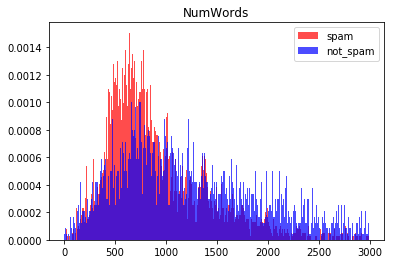

In [300]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

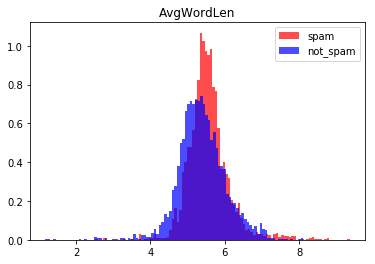

In [301]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

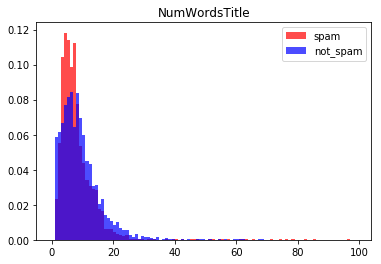

In [302]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 100, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

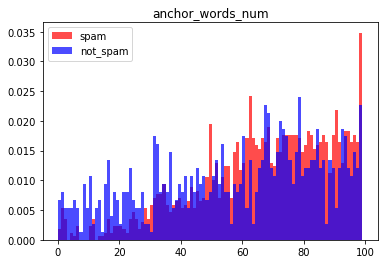

In [303]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 100, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('anchor_words_num')
plt.legend()
plt.show()

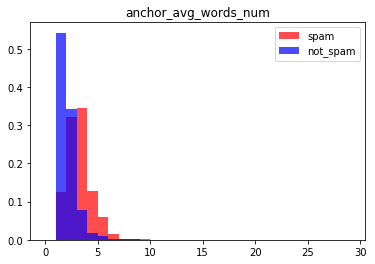

In [304]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('anchor_avg_words_num')
plt.legend()
plt.show()

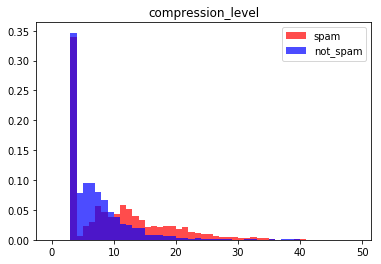

In [305]:
is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
bins = range(0, 50, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('compression_level')
plt.legend()
plt.show()

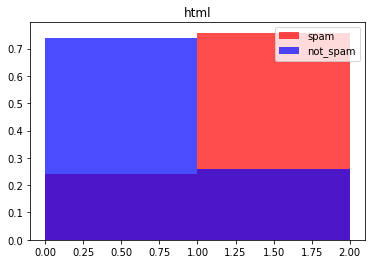

In [306]:
is_spam_data = [doc.features[6] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[6] for doc in train_docs if doc[1] == False]
bins = range(0, 3, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('html')
plt.legend()
plt.show()

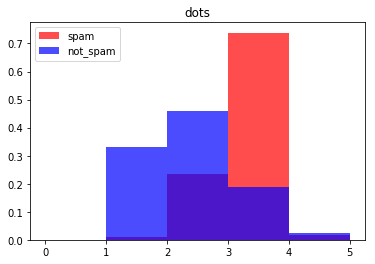

In [307]:
is_spam_data = [doc.features[7] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[7] for doc in train_docs if doc[1] == False]
bins = range(0, 6, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('dots')
plt.legend()
plt.show()

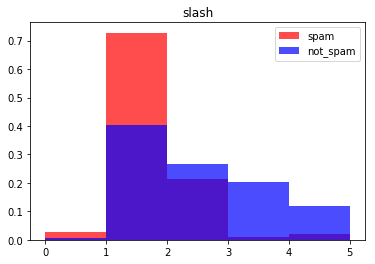

In [308]:
is_spam_data = [doc.features[8] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[8] for doc in train_docs if doc[1] == False]
bins = range(0, 6, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('slash')
plt.legend()
plt.show()

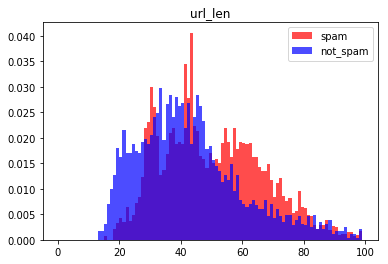

In [309]:
is_spam_data = [doc.features[9] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[9] for doc in train_docs if doc[1] == False]
bins = range(0, 100, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('url_len')
plt.legend()
plt.show()

In [310]:
# is_spam_data = [doc.features[10] for doc in train_docs if doc[1] == True]
# not_spam_data = [doc.features[10] for doc in train_docs if doc[1] == False]
# bins = range(0, 50, 1)
# plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
# plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
# plt.title('img_tag')
# plt.legend()
# plt.show()

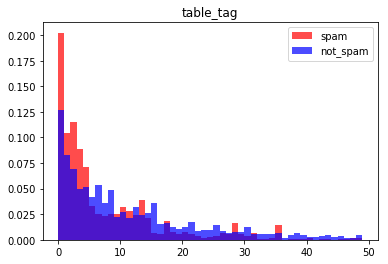

In [311]:
is_spam_data = [doc.features[10] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[10] for doc in train_docs if doc[1] == False]
bins = range(0, 50, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('table_tag')
plt.legend()
plt.show()

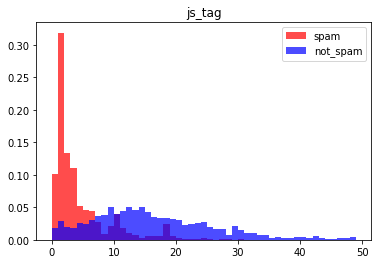

In [312]:
is_spam_data = [doc.features[11] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[11] for doc in train_docs if doc[1] == False]
bins = range(0, 50, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('js_tag')
plt.legend()
plt.show()

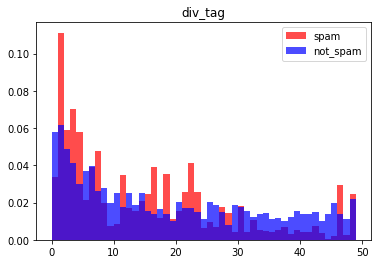

In [313]:
is_spam_data = [doc.features[12] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[12] for doc in train_docs if doc[1] == False]
bins = range(0, 50, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('div_tag')
plt.legend()
plt.show()

** Классификатор: **
Нужно реализовать  
(.)(.)

In [314]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

class Classifier:
    
    def __init__(self):
        self.clf = GradientBoostingClassifier(n_estimators = 1000, min_samples_split = 4, max_depth = 3)
#         self.clf = RandomForestClassifier()
    
    def predict(self, doc):
        features = np.array([doc.features])
        features = np.nan_to_num(features)
        return self.clf.predict(features)                   
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def train(self, docs):                
#         for doc_num, doc in enumerate(docs):                            
#             #TODO вставить код обучения
#             trace(doc_num)
#         trace(doc_num, 1)
        features = np.array([doc.features for doc in docs]).astype("float32")
        targets =  np.array([doc.is_spam for doc in docs]).astype("float32")
        features = np.nan_to_num(features)
        targets = np.nan_to_num(targets)

        self.clf = self.clf.fit(features, targets)

In [315]:
from sklearn.model_selection import train_test_split

train = train_docs
test = train_docs[6500:]

classifier = Classifier()
%time
classifier.train(train)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 5.01 µs


In [316]:
#Посмотреть, что предсказывается для тестового html
classifier.predict(DocItem(0, 0, test_url , test_features))

array([0.], dtype=float32)

** Рисуем графики **

23:38:48 INFO:Complete items 00000


threshold 0
	class_prec 0.993610223642, class_recall 0.990445859873, class_F1 0.992025518341
	not_class_prec 0.987012987013, not_class_recall 0.991304347826, not_class_F1 0.989154013015
		MacroF1Mesure 0.990589765678
threshold 0.1
	class_prec 0.993610223642, class_recall 0.990445859873, class_F1 0.992025518341
	not_class_prec 0.987012987013, not_class_recall 0.991304347826, not_class_F1 0.989154013015
		MacroF1Mesure 0.990589765678
threshold 0.2
	class_prec 0.993610223642, class_recall 0.990445859873, class_F1 0.992025518341
	not_class_prec 0.987012987013, not_class_recall 0.991304347826, not_class_F1 0.989154013015
		MacroF1Mesure 0.990589765678
threshold 0.3
	class_prec 0.993610223642, class_recall 0.990445859873, class_F1 0.992025518341
	not_class_prec 0.987012987013, not_class_recall 0.991304347826, not_class_F1 0.989154013015
		MacroF1Mesure 0.990589765678
threshold 0.4
	class_prec 0.993610223642, class_recall 0.990445859873, class_F1 0.992025518341
	not_class_prec 0.987012987013,

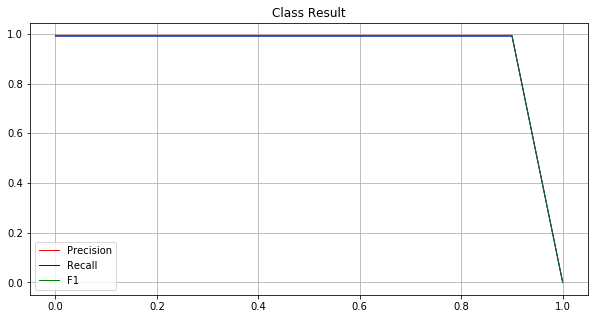

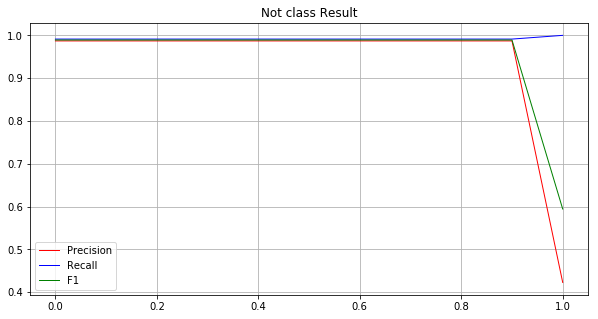

In [317]:
plot_results(test, min_threshold=0, max_threshold=1, step=0.1, trace=1)

In [318]:
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = load_csv(TEST_DATA_FILE, calc_features)

threshold = 0.5

with open('my_submission.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3] > threshold else 0
        writer.writerow([item[0], prediction])

23:38:48 INFO:Complete items 00000
23:38:48 INFO:Complete items 00000
23:39:05 INFO:Complete items 01000
23:39:05 INFO:Complete items 01000
23:39:20 INFO:Complete items 02000
23:39:20 INFO:Complete items 02000
23:39:34 INFO:Complete items 03000
23:39:34 INFO:Complete items 03000
23:39:47 INFO:Complete items 04000
23:39:47 INFO:Complete items 04000
23:39:59 INFO:Complete items 05000
23:39:59 INFO:Complete items 05000
23:40:14 INFO:Complete items 06000
23:40:14 INFO:Complete items 06000
23:40:27 INFO:Complete items 07000
23:40:27 INFO:Complete items 07000
23:40:40 INFO:Complete items 08000
23:40:40 INFO:Complete items 08000
23:40:53 INFO:Complete items 09000
23:40:53 INFO:Complete items 09000
23:41:11 INFO:Complete items 10000
23:41:11 INFO:Complete items 10000
23:41:24 INFO:Complete items 11000
23:41:24 INFO:Complete items 11000
23:41:38 INFO:Complete items 12000
23:41:38 INFO:Complete items 12000
23:41:50 INFO:Complete items 13000
23:41:50 INFO:Complete items 13000
23:42:04 INFO:Comple